# Analysis on the energy requirements for milling and pelleting of feedstock
Notes:
- This is an update to work in previous notebook
- This version adds some additional data from another literature source
- Linear regression models are fit and used to make predictions.
- Some model steps differentiate between feedstock types - i.e. herbaceous and woody.

In [334]:
# Import packages and load and display milling and pelleting data
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from sklearn.metrics import mean_squared_error

directory = os.getcwd()
data = pd.read_csv("milling_pelleting_data.csv")
data

,Energy consumption milling [kWh/tonne],Energy consumption pelleting [kWh/tonne],Screen size [mm],Particle size [mm],Feedstock,Feedstock type,Source
0,18.55,45.20,4.76,0.52,switchgrass,herbaceous biomass,10.1166/jbmb.2013.1390
1,49.97,124.13,4.76,0.81,eucalyptus,woody biomass,10.1166/jbmb.2013.1390
2,43.21,48.94,4.76,0.65,lodgepole pine,woody biomass,10.1166/jbmb.2013.1390
3,34.54,56.43,4.76,0.57,corn stover,herbaceous biomass,10.1166/jbmb.2013.1390
4,38.58,122.86,3.20,15.00,corn stover,herbaceous biomass,10.13031/aea.30.9719
5,32.26,92.80,3.20,15.00,sorghum stalks,herbaceous biomass,10.13031/aea.30.9719
6,36.88,118.99,3.20,15.00,big bluestem,herbaceous biomass,10.13031/aea.30.9719
7,28.13,105.04,3.20,18.00,wheat straw,herbaceous biomass,10.13031/aea.30.9719
8,14.07,122.58,6.50,25.00,corn stover,herbaceous biomass,10.13031/aea.30.9719
9,13.67,99.42,6.50,20.00,sorghum stalks,herbaceous biomass,10.13031/aea.30.9719


In [335]:
woody_data = data[data["Feedstock type"]=="woody biomass"]
woody_data

,Energy consumption milling [kWh/tonne],Energy consumption pelleting [kWh/tonne],Screen size [mm],Particle size [mm],Feedstock,Feedstock type,Source
1,49.97,124.13,4.76,0.81,eucalyptus,woody biomass,10.1166/jbmb.2013.1390
2,43.21,48.94,4.76,0.65,lodgepole pine,woody biomass,10.1166/jbmb.2013.1390


In [336]:
herbaceous_data = data[data["Feedstock type"]=="herbaceous biomass"]
herbaceous_data


,Energy consumption milling [kWh/tonne],Energy consumption pelleting [kWh/tonne],Screen size [mm],Particle size [mm],Feedstock,Feedstock type,Source
0,18.55,45.20,4.76,0.52,switchgrass,herbaceous biomass,10.1166/jbmb.2013.1390
3,34.54,56.43,4.76,0.57,corn stover,herbaceous biomass,10.1166/jbmb.2013.1390
4,38.58,122.86,3.20,15.00,corn stover,herbaceous biomass,10.13031/aea.30.9719
5,32.26,92.80,3.20,15.00,sorghum stalks,herbaceous biomass,10.13031/aea.30.9719
6,36.88,118.99,3.20,15.00,big bluestem,herbaceous biomass,10.13031/aea.30.9719
7,28.13,105.04,3.20,18.00,wheat straw,herbaceous biomass,10.13031/aea.30.9719
8,14.07,122.58,6.50,25.00,corn stover,herbaceous biomass,10.13031/aea.30.9719
9,13.67,99.42,6.50,20.00,sorghum stalks,herbaceous biomass,10.13031/aea.30.9719
10,13.49,168.08,6.50,31.00,big bluestem,herbaceous biomass,10.13031/aea.30.9719
11,14.00,172.87,6.50,31.00,wheat straw,herbaceous biomass,10.13031/aea.30.9719


# Define required functions

In [337]:
# Create function to fit linear regression to data and calculate the corresponding RMSE of the regression model

def fit_linear_regression_with_rmse(x, y, display=True):
    regression_function = Polynomial.fit(x=list(x), y=list(y), deg=1)
    predictions = []
    for x_variable in list(x):
        predictions.append(regression_function(x_variable))
    rmse = mean_squared_error(y, predictions, squared=False)

    try:
        labels = {"x_label": x.name, "y_label": y.name}
    except:
        labels = "Could not be extracted from function inputs"

    x_limits = {"min": x.min(), "max": x.max()}
    if display:
        print("Regression function:", regression_function)
        print("RMSE:", rmse)
        print("X limits:", x_limits)
        print("Labels:", labels)

    output = {"Regression function": regression_function,
              "RMSE": rmse,
              "Labels": labels,
              "X_limits": x_limits
              }

    return output

# Study milling data

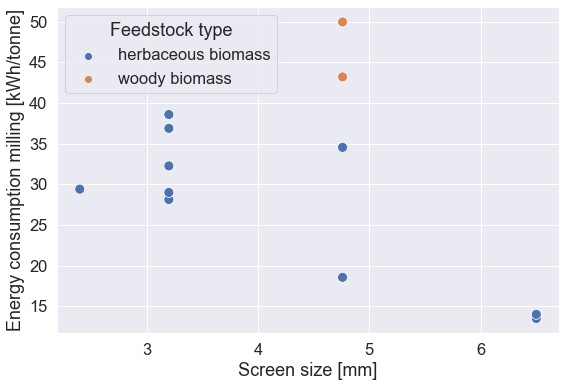

In [338]:
# Plot milling data - all
plt.figure(figsize=(9,6))
sns.set(font_scale=1.5)
sns.scatterplot(data=data,x="Screen size [mm]", y="Energy consumption milling [kWh/tonne]", hue="Feedstock type", s=100)
plt.savefig(directory + r"\figures\energy_milling_all.tiff", dpi=500, bbox_inches = "tight")
plt.show()


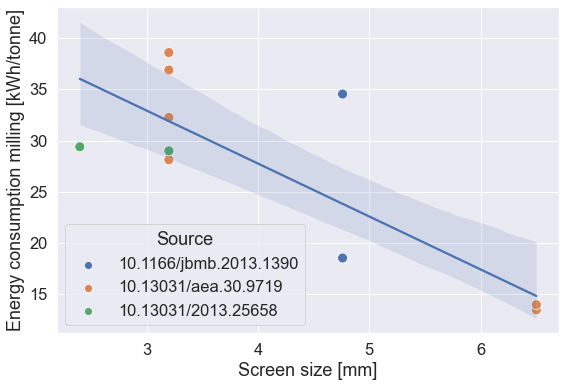

In [339]:
# Plot milling data - herbaceous biomass
plt.figure(figsize=(9,6))
sns.set(font_scale=1.5)
sns.scatterplot(data=herbaceous_data,x="Screen size [mm]", y="Energy consumption milling [kWh/tonne]", hue="Source", s=100)
sns.regplot(data=herbaceous_data,x="Screen size [mm]", y="Energy consumption milling [kWh/tonne]", scatter=False)
plt.savefig(directory + r"\figures\energy_milling_herbaceous.tiff", dpi=500, bbox_inches = "tight")
plt.show()


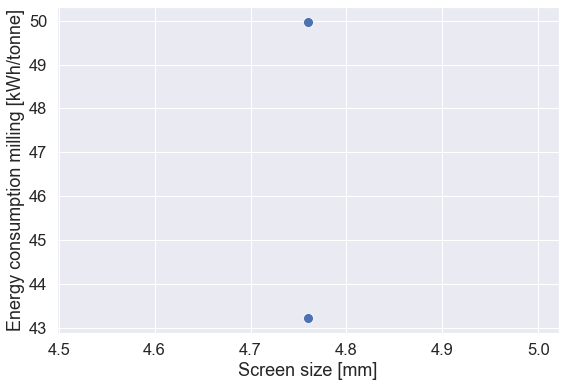

In [340]:
# Plot milling data - woody biomass
plt.figure(figsize=(9,6))
sns.set(font_scale=1.5)
sns.scatterplot(data=woody_data,x="Screen size [mm]", y="Energy consumption milling [kWh/tonne]", s=100)
plt.show()


In [341]:
# Create regression model for herbaceous biomass

energy_milling_model = fit_linear_regression_with_rmse(herbaceous_data["Screen size [mm]"], herbaceous_data["Energy consumption milling [kWh/tonne]"])


Regression function: 25.437993814954478 - 10.588745861307833 x**1
RMSE: 4.85818206542887
X limits: {'min': 2.4, 'max': 6.5}
Labels: {'x_label': 'Screen size [mm]', 'y_label': 'Energy consumption milling [kWh/tonne]'}


In [342]:
# Compare woody to herbaceous biomass

print("Herbaceous biomass predicted average consumption for 4.7 screen:", energy_milling_model["Regression function"](4.76))
print("Average value for woody biomass at same screensize:", np.mean(list(woody_data["Energy consumption milling [kWh/tonne]"])))
difference_herbaceous_woody_milling = abs(np.mean(list(woody_data["Energy consumption milling [kWh/tonne]"]))- energy_milling_model["Regression function"](4.76))
print("Approximate difference in energy consumption:", difference_herbaceous_woody_milling)


Herbaceous biomass predicted average consumption for 4.7 screen: 23.83676883104939
Average value for woody biomass at same screensize: 46.59
Approximate difference in energy consumption: 22.753231168950613


# Compare particle size resulting from different screen sizes

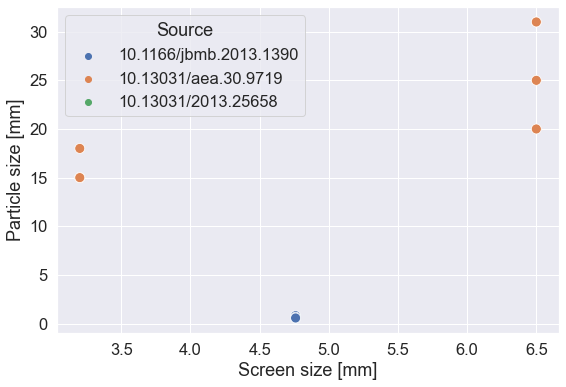

In [343]:
# Plot particle size - all
plt.figure(figsize=(9,6))
sns.set(font_scale=1.5)
sns.scatterplot(data=data,x="Screen size [mm]", y="Particle size [mm]", hue="Source", s=100)
plt.savefig(directory + r"\figures\particle_size_based_on_screen_size_all.tiff", dpi=500, bbox_inches = "tight")
plt.show()


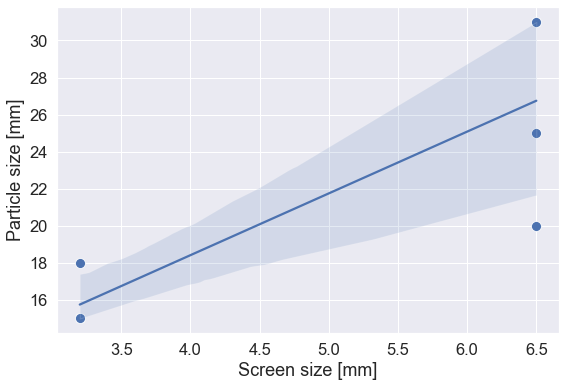

In [344]:
# Plot particle size - Only Wilson et al. data
plt.figure(figsize=(9,6))
sns.set(font_scale=1.5)
sns.scatterplot(data=data[data["Source"]=="10.13031/aea.30.9719"], x="Screen size [mm]", y="Particle size [mm]", s=100)
sns.regplot(data=data[data["Source"]=="10.13031/aea.30.9719"], x="Screen size [mm]", y="Particle size [mm]", scatter=False)
plt.savefig(directory + r"\figures\particle_size_based_on_screen_size_wilson.tiff", dpi=500, bbox_inches = "tight")
plt.show()

In [345]:
particle_size_milling_model = fit_linear_regression_with_rmse(data[data["Source"]=="10.13031/aea.30.9719"]["Screen size [mm]"], data[data["Source"]=="10.13031/aea.30.9719"]["Particle size [mm]"])


Regression function: 21.249999999999996 + 5.5000000000000036 x**1
RMSE: 3.3819373146171707
X limits: {'min': 3.2, 'max': 6.5}
Labels: {'x_label': 'Screen size [mm]', 'y_label': 'Particle size [mm]'}


# Study pelleting data

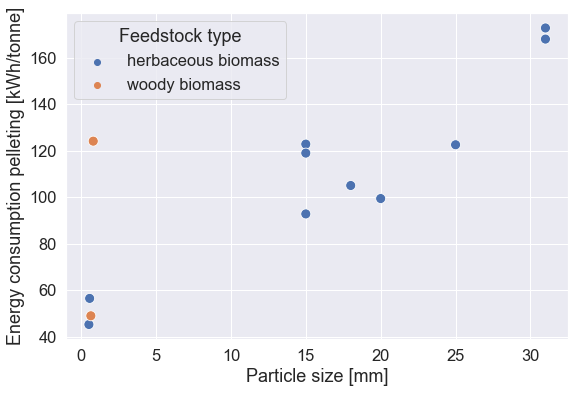

In [346]:
# Plot pelleting data - all
plt.figure(figsize=(9,6))
sns.set(font_scale=1.5)
sns.scatterplot(data=data,x="Particle size [mm]", y="Energy consumption pelleting [kWh/tonne]", hue="Feedstock type", s=100)
plt.savefig(directory + r"\figures\energy_pelleting_all.tiff", dpi=500, bbox_inches = "tight")
plt.show()


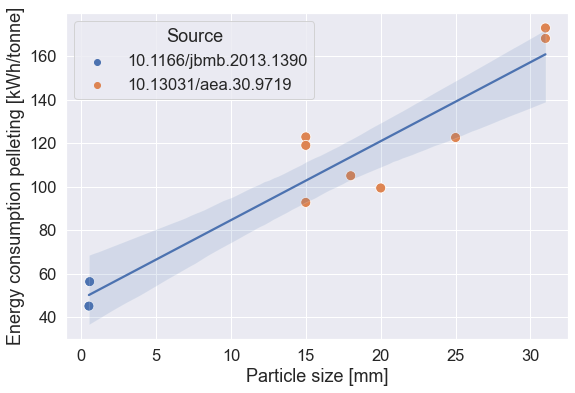

In [347]:
# Plot pelleting data - herbaceous
plt.figure(figsize=(9,6))
sns.set(font_scale=1.5)
sns.scatterplot(data=herbaceous_data[herbaceous_data["Source"]!="10.13031/2013.25658"],x="Particle size [mm]", y="Energy consumption pelleting [kWh/tonne]", hue="Source", s=100)
sns.regplot(data=herbaceous_data[herbaceous_data["Source"]!="10.13031/2013.25658"],x="Particle size [mm]", y="Energy consumption pelleting [kWh/tonne]", scatter=False)
plt.savefig(directory + r"\figures\energy_pelleting_herbaceous.tiff", dpi=500, bbox_inches = "tight")
plt.show()


In [348]:
energy_pelleting_model = fit_linear_regression_with_rmse(x=herbaceous_data[herbaceous_data["Source"]!="10.13031/2013.25658"]["Particle size [mm]"], y=herbaceous_data[herbaceous_data["Source"]!="10.13031/2013.25658"]["Energy consumption pelleting [kWh/tonne]"])


Regression function: 105.53667796800109 + 55.24722592117381 x**1
RMSE: 13.538351800197661
X limits: {'min': 0.52, 'max': 31.0}
Labels: {'x_label': 'Particle size [mm]', 'y_label': 'Energy consumption pelleting [kWh/tonne]'}


# Save all important data to pickle file

In [349]:
# Store for later use

output_dict = {"Energy milling model": energy_milling_model,
               "Difference energy requirement milling - herbaceous and woody biomass": difference_herbaceous_woody_milling,
               "Particle size from milling": particle_size_milling_model,
               "Pelleting model": energy_pelleting_model
               }

# Store Peformance summary data frame of best performing model
with open("results\milling_pelleting_results", "wb") as f:
    pickle.dump(output_dict, f)

# Also save to data folder
with open(r"C:\Users\2270577A\PycharmProjects\PhD_LCA_TEA\data\milling_pelleting_results", "wb") as f:
    pickle.dump(output_dict, f)


In [350]:
# Example of how pickled data frame can be loaded
with open("results\milling_pelleting_results", "rb") as f:
    loaded_dict = pickle.load(f)

loaded_dict


{'Energy milling model': {'Regression function': Polynomial([ 25.43799381, -10.58874586], domain=[2.4, 6.5], window=[-1.,  1.]),
  'RMSE': 4.85818206542887,
  'Labels': {'x_label': 'Screen size [mm]',
   'y_label': 'Energy consumption milling [kWh/tonne]'},
  'X_limits': {'min': 2.4, 'max': 6.5}},
 'Difference energy requirement milling - herbaceous and woody biomass': 22.753231168950613,
 'Particle size from milling': {'Regression function': Polynomial([21.25,  5.5 ], domain=[3.2, 6.5], window=[-1.,  1.]),
  'RMSE': 3.3819373146171707,
  'Labels': {'x_label': 'Screen size [mm]', 'y_label': 'Particle size [mm]'},
  'X_limits': {'min': 3.2, 'max': 6.5}},
 'Pelleting model': {'Regression function': Polynomial([105.53667797,  55.24722592], domain=[ 0.52, 31.  ], window=[-1.,  1.]),
  'RMSE': 13.538351800197661,
  'Labels': {'x_label': 'Particle size [mm]',
   'y_label': 'Energy consumption pelleting [kWh/tonne]'},
  'X_limits': {'min': 0.52, 'max': 31.0}}}

# Conclusions:
- Generally findings agree well with each other.
- Woody biomass seems to require more energy for milling
- Too much uncertainty to say if it requires more for pelleting or not
- Particle size after milling does not agree well between different studies